In [633]:
import geopandas as gpd
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as py
from shapely.geometry import Point
import sys
!{sys.executable} -m pip install mapclassify
import sys
!{sys.executable} -m pip install xlr
from shapely.geometry import Point
import sys
!{sys.executable} -m pip install folium
import folium
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
import math

ERROR: Could not find a version that satisfies the requirement xlr
ERROR: No matching distribution found for xlr


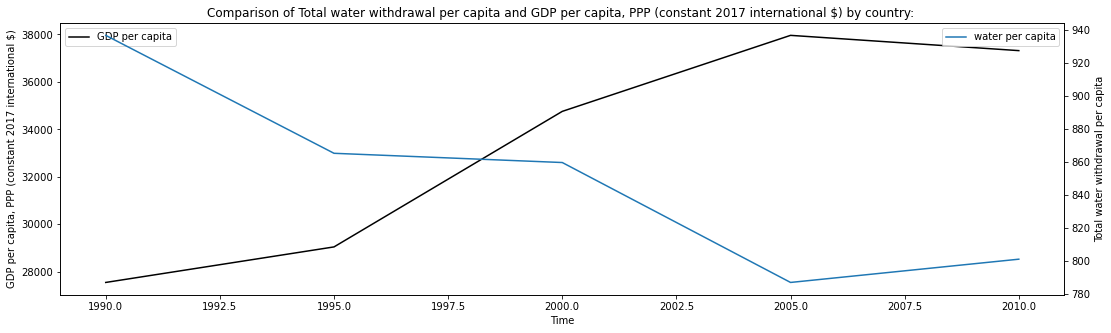

     Entity Code  GDP per capita, PPP (constant 2017 international $)  \
Year                                                                    
1990  Spain  ESP                                       27543.919244     
1995  Spain  ESP                                       29042.344144     
2000  Spain  ESP                                       34757.615022     
2005  Spain  ESP                                       37963.365836     
2010  Spain  ESP                                       37319.476223     

      Total water withdrawal per capita  
Year                                     
1990                              936.6  
1995                              865.1  
2000                              859.5  
2005                              786.8  
2010                              800.9  


In [649]:
# The first two lines extract the data from the csv file and then merge it together using the inner join method. This method will return a dataframe that contains only the rows that share common characteristics 
gdppc = pd.read_csv("gdp-per-capita-worldbank.csv")
waterppc = pd.read_csv("water-withdrawals-per-capita.csv")
waterxgdp = gdppc.merge(waterppc, how = "inner")
# this line will set the column Year as the index of the dataframe
waterxgdp = waterxgdp.set_index('Year')
waterxgdp
fig, ax = plt.subplots(figsize=(18,5))
# what this function does basically:
# it takes a country of the dataframe, the one that the author wants to study (in this case India). then creates a time plot with two y axis, so you can compare the evolution of the two variables across time  
def country(data):
    ax.plot(data.index, data["GDP per capita, PPP (constant 2017 international $)"], color = "black", label = "GDP per capita")
    ax.set_xlabel("Time")
    ax.set_ylabel("GDP per capita, PPP (constant 2017 international $)")
    ax2 = ax.twinx()
    ax2.plot(data.index, data["Total water withdrawal per capita"], label = "water per capita")
    ax2.set_ylabel("Total water withdrawal per capita")
    ax.legend()
    ax2.legend(loc = 'upper right')
    plt.title("Comparison of Total water withdrawal per capita and GDP per capita, PPP (constant 2017 international $) by country: ")
    plt.show()
# The reason behind this complicated way to retrieve the country, is that the countries are part of an specific column named Entity
country(waterxgdp.loc[(waterxgdp["Entity"]=="Spain")])
print(waterxgdp.loc[(waterxgdp["Entity"]=="Spain")])

# Answers
For the GLS regression we obtain the following turning points (in annual GDP per capita terms): <br /> 
Total water withdrawal per capita: **10.51 dollars** <br /> 
Industry water withdrawal: **157 dollars** <br /> 
Agriculture water withdrawal: **32 dollars** <br /> 
Domestic water withdrawal: **17 dollars** <br /> 

# Data:
## Stacked Bar Plots:
In the following bar plot what we can see is that the weight of agriculture has gone down in the recent years while the weight of Industrial and Domestic has increased over the years. What this could mean is that more and more countries are starting to develop and they are leaving the low income area. 

<ipython-input-579-2cf76e4243b7>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(avgwater.index, rotation = 90)


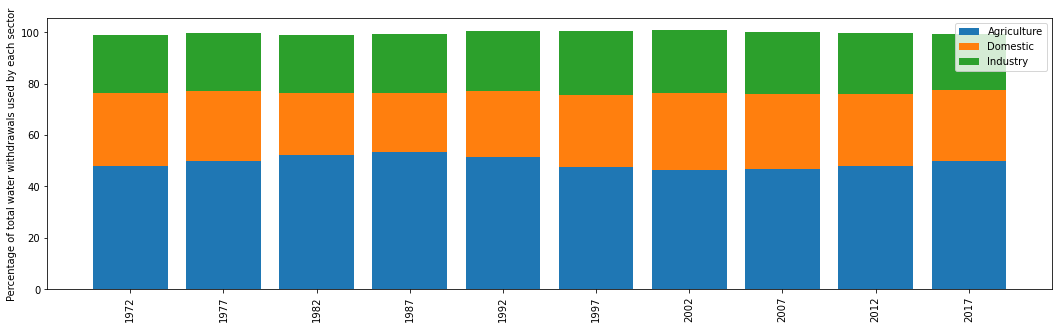

,Industry,Agriculture,Domestic
1972,22.409971,48.121327,28.304157
1977,22.644930,49.718337,27.217485
1982,22.742145,52.099348,24.211167
1987,22.982758,53.574462,22.567724
1992,23.444690,51.353332,25.686009
1997,24.896602,47.717033,27.971248
2002,24.342688,46.276331,30.033660
2007,23.931721,46.718130,29.285072
2012,23.881668,48.034562,27.825466
2017,21.626750,49.823665,27.789974


In [579]:
# reads the data from excel and transforms it into a dataframe
waterAgr = pd.read_excel("AgriculturalWater.xls", engine = "xlrd", header = 3 )
# drops rows with na values
waterAgr = waterAgr.dropna(0)
# calculates the mean of every row
avgwater["Agriculture"] = pd.DataFrame(waterAgr.mean(axis=0))
waterInd = pd.read_excel("IndustrialWater.xls", engine = "xlrd", header = 3 )
waterInd = waterInd.dropna(0)
avgwater["Industry"] = pd.DataFrame(waterInd.mean(axis=0))
waterDom = pd.read_excel("domestic_water.xls", engine = "xlrd", header = 3 )
waterDom = waterDom.dropna(0)
avgwater["Domestic"] = pd.DataFrame(waterDom.mean(axis=0))
# this line will store the first three columns of the database
avgwater = avgwater.iloc[: , :3]
# This chunk  of code creates the plot seen below.
fig, ax = plt.subplots(figsize=(18,5))
ax.bar(avgwater.index, avgwater["Agriculture"], label = "Agriculture")
ax.bar(avgwater.index, avgwater["Domestic"], bottom=avgwater["Agriculture"], label = "Domestic")
ax.bar(avgwater.index, avgwater["Industry"], bottom=avgwater["Agriculture"]+avgwater["Domestic"], label = "Industry")
ax.set_xticklabels(avgwater.index, rotation = 90)
ax.set_ylabel("Percentage of total water withdrawals used by each sector")
ax.legend()
plt.show()


## Maps

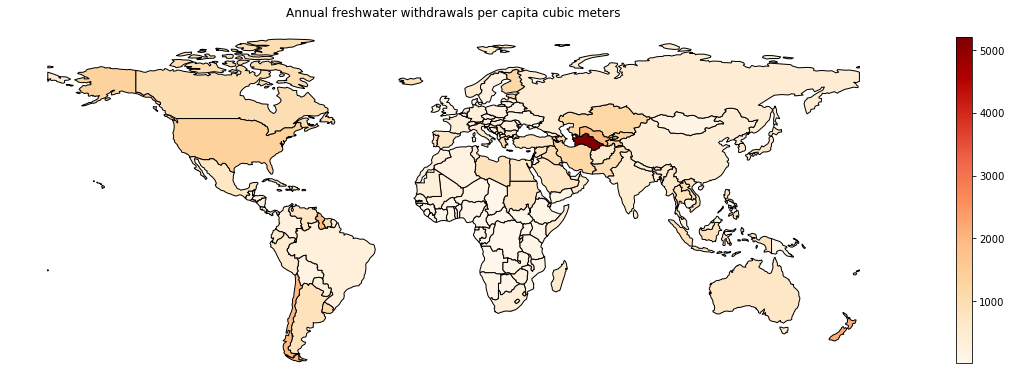

In [594]:

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#what this line of code does is the following: alphabethically sorts the dataframe world based on the unicode "NFKD" format and then resets the index.
#we call iloc because the code inside the [] will return a series of integers that need to be reordered
world1 = (world.iloc[world['name'].str.normalize('NFKD').argsort()]).reset_index()
#this line of code will drop Antartica, in the previous line what we did is to order alphabetically but also reorder the index
world1.drop(4, inplace = True)
water1 = pd.read_excel("TotalWaterMap.xls", engine = "xlrd", header = 3 )
# What this line of code does is obtain a list of countries that do not have an iso_a3 equal to the code of the excel database and then print the name of that country and what they have as an ISO code 
world1[~world1['iso_a3'].isin(list(water1['Country Code']))][['iso_a3', 'name']]
#This line updates the Iso Codes of the countries that do not have a correct ISO code
world1.loc[world1.name == 'France', 'iso_a3'] = 'FRA'
world1.loc[world1.name == 'Norway', 'iso_a3'] = 'NOR'
# in this line what we do is merge the two dataframes, we use how = left to maintain every row of the left dataframe which is the map in this case. 
water1 = world1.merge(water1,
                            left_on = 'iso_a3',
                            right_on = 'Country Code',
                            how = 'left',)
# what this function does: It takes a specific year of the dataframe water1, and also the dataframe itself and returns a colorised map that ranks the counntries by water withdrawals in cubic meters 
def newmap (date, water):
    #water per capita in billion cubic meters
    water["percapita"] = date/(water["pop_est"]/1000000000)
    # what this two lines do is create a map where the color of each country is determined by the percapita value
    axes = water.plot(column= "percapita",  edgecolor = "black", legend = True, legend_kwds={'shrink': 0.3}, cmap = "OrRd")
    axes.set_axis_off()
    plt.title("Annual freshwater withdrawals per capita cubic meters")
# this line sets the figure size of the map
    plt.rcParams["figure.figsize"]=20,20
    plt.show()
    
    
newmap(water1["2017"],water1)



In [596]:
waterorder=water1.sort_values(by=['percapita'], ascending = False)
waterorder.head()


,index,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Country Name,Country Code,1977,1982,1987,1992,1997,2002,2007,2012,2017,percapita
160,106,5351277,Asia,Turkmenistan,TKM,94720.0,"POLYGON ((52.50246 41.78332, 52.94429 42.11603...",Turkmenistan,TKM,NaN,NaN,NaN,NaN,24.262550,26.002367,27.865000,27.865000,27.8650,5207.168308
111,136,4510327,Oceania,New Zealand,NZL,174800.0,"MULTIPOLYGON (((176.88582 -40.06598, 176.50802...",New Zealand,NZL,NaN,1.48,2.077143,2.5200,2.962857,3.897714,4.981250,7.538000,9.8750,2189.419969
29,10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...",Chile,CHL,NaN,NaN,NaN,20.2852,25.692343,31.089536,35.368000,35.368000,35.3680,1988.165111
167,6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",Uzbekistan,UZB,NaN,NaN,NaN,NaN,53.571143,52.595000,49.448889,50.171111,58.9000,1979.907868
65,41,737718,South America,Guyana,GUY,6093.0,"POLYGON ((-56.53939 1.89952, -56.78270 1.86371...",Guyana,GUY,NaN,NaN,NaN,1.4600,1.572500,1.609280,1.515800,1.444700,1.4447,1958.336383


Text(0.5, 1.0, 'Annual freshwater withdrawals, Domestic (% of total freshwater withdrawal 2012')

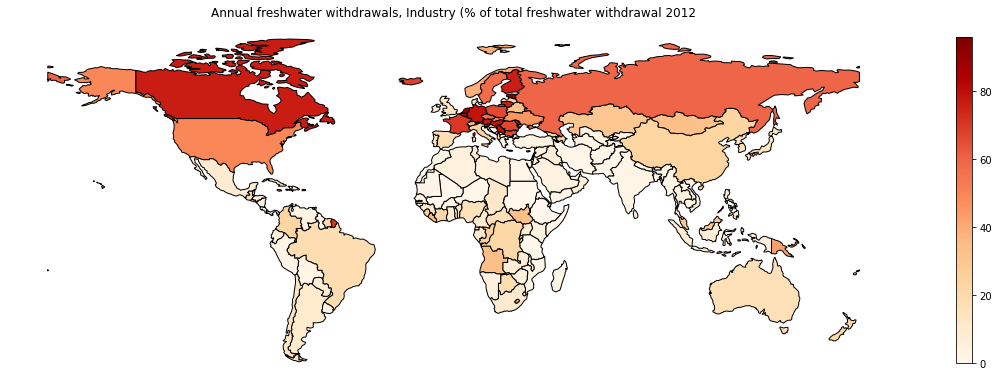

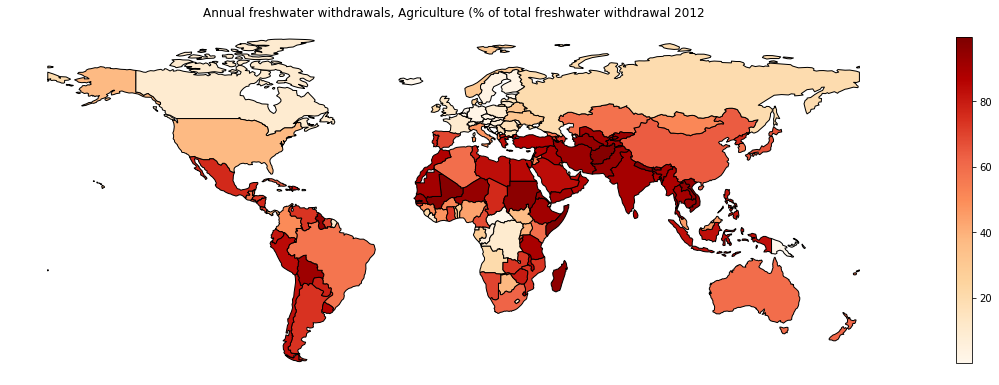

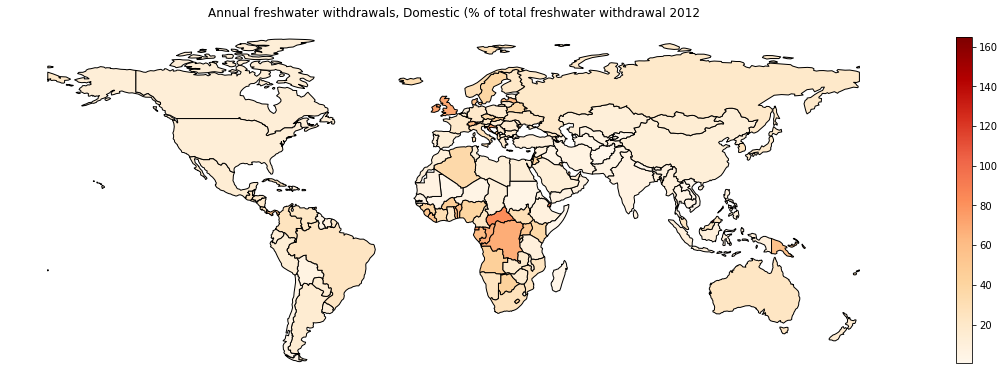

In [653]:
waterInd = pd.read_excel("IndustrialWater.xls", engine = "xlrd", header = 3 )
waterDom = pd.read_excel("domestic_water.xls", engine = "xlrd", header = 3 )
waterAgr = pd.read_excel("AgriculturalWater.xls", engine = "xlrd", header = 3 )
# what this function does: it takes any year and the database that the author wants to collect information from, then it is merged with the map of the world of geopandas 
# what is singular of this map is the use of the if statement to change the title that is returned, we do this because we want to get information from three databases and we want to get a correct title for each of them. 
def newsectormap (date, water):
    water1 = world1.merge(water,
                            left_on = 'iso_a3',
                            right_on = 'Country Code',
                            how = 'left',)
    axes = water1.plot(column= date,  edgecolor = "black", legend = True, legend_kwds={'shrink': 0.3}, cmap = "OrRd")
    axes.set_axis_off()
    if water is waterInd:
        return plt.title("Annual freshwater withdrawals, Industry (% of total freshwater withdrawal " + date)
    if water is waterAgr:
        return plt.title("Annual freshwater withdrawals, Agriculture (% of total freshwater withdrawal " + date)
    if water is waterDom: 
        return plt.title("Annual freshwater withdrawals, Domestic (% of total freshwater withdrawal " + date)
    return none
    plt.rcParams["figure.figsize"]=20,20
    plt.show()

newsectormap("2012", waterInd)
newsectormap("2012", waterAgr)
newsectormap("2012", waterDom)
# this line sorts the value of the Agricultural water dataframe and gives us the top 5 countries that have a higher percentage of their use in this sector



## Analysis of the Sectors:
In the year 2017 (we take this year because we do the regressions based on this specific year). We see big differences between the uses that country make of their water. Starting with the Industry one, we see countries using up to 96 of their total water withdrawals in this sector. Also in this sector we see more mix between developed countries (Estonia, Netherlands, Germany) and countries that are developing (Jamaica). On the other hand, we have the Agriculture sector, here we find that the top 5 share a specific characteristic: They are extremely underdeveloped. Finally we have the domestic sector, here the top 5 has also similar characteristics, all of them are small countries with no important industry and there economy is focused on the service sector (Tourism and Banking mostly).

In [655]:
print(waterInd.sort_values(by=['2017'], ascending = False).head())
print(waterAgr.sort_values(by=['2017'], ascending = False).head())
print(waterDom.sort_values(by=['2017'], ascending = False).head())

    Country Name Country Code  1972  1977  1982  1987       1992       1997  \
71       Estonia          EST   NaN   NaN   NaN   NaN  85.665399  92.463242   
176  Netherlands          NLD   NaN   NaN   NaN   NaN  80.768032  78.932842   
222     Slovenia          SVN   NaN   NaN   NaN   NaN        NaN        NaN   
117      Jamaica          JAM   NaN   NaN   NaN   NaN        NaN   7.619953   
55       Germany          DEU   NaN   NaN   NaN   NaN        NaN  83.080240   

          2002       2007       2012       2017  
71   99.564484  82.350474  95.953403  96.419968  
176  85.953791  87.944908  88.089376  91.686623  
222  78.458630  81.602310  82.329490  81.382865  
117   8.443109  26.945055  54.638801  81.240768  
55   83.495387  80.928793  78.899787  80.817753  
    Country Name Country Code  1972  1977  1982       1987       1992  \
213      Somalia          SOM   NaN   NaN   NaN  97.037037  98.944614   
2    Afghanistan          AFG   NaN   NaN   NaN  99.000042  98.851645   
178   

# Method
We will use the following data:
Total water withdrawals per capita, Annual freshwater withdrawals Industry (% of total freshwater withdrawal), Annual freshwater withdrawals Agriculture (% of total freshwater withdrawals), Annual freshwater withdrawals, Domestic (% of total freshwater withdrawal and GDP per capita, PPP (constant 2017 international dollars). The reason that we use this databases is to get a better picture of how countries differ in their water uses, and also try to explain the different turning points that we get in the results. As an example: when a country starts to develop, it increases it's use of industrial water and domestic while the Agricultural one diminishes. <br />
The total withdrawals and GDP are in per capita terms while the Industry, Agriculture and Domestic are in percentage terms, the reason behing this is that Industry, Agriculture and Domestic were not available. <br />
To try an answer the question we will two econometric approaches: <br />
The first one is a cross sectional GLS. We use a reduced form with only one explanatory variable in this case GDP (in both linear and squared versions), which means we can only test for correlations not causation, we do this following the advide of the existing literature: \begin{equation} Water_i = \beta_0 + \beta_1GDP_i + \beta_2GDP_i + \epsilon_i \end{equation} <br />
The form of the regression is log log, we do it this way to correct for possible outliers in the data.
To perform a correct analysis what we do first is test for heteroscedasticity, using the breusch pagan test.
As we will see every sector rejects the null hypothesis meaning that we have heteroscedasticity.
After we have perform the GLS regression and obtained the coefficients we will then proceed and calculate the turning points of each sector.   
To calculate the turning use we will use the formula proposed by Song Tao(2008): \begin{equation} T=
e^{-\beta_1/(2*\beta_2)} \end{equation}

# Assumptions:
We have three main assumptions for the GLS regression: <br />
**1st**: We perform a GLS to account for the Heteroscedasticity that is found in the data. waterInd.sort_values <br />
**2nd**:For the explanatory variables (GDP), we take the mean value of a period instead of taking a single year (as we do with water), we do this because we want to evaluate the turning point of the economy. <br />
**3rd**: The year that we choose for total water withdrawals changes from the one we took in the sector, the reason why is the unavailability of the data for that year. 


In [693]:
#gdppc = gdppc.pivot(index='Entity', columns='Year', values='GDP per capita, PPP (constant 2017 international $)')
#waterppc = waterppc.pivot(index='Entity', columns='Year', values='Total water withdrawal per capita')
#waterppc = waterppc.reset_index()
#gdppc = gdppc.reset_index()
gdppc['mean'] = gdppc.mean(axis=1)
gdppc["lGDPxc"] = np.log10(gdppc["mean"])
gdppc["lGDPxcsq"] = np.log10(gdppc["mean"])**2
waterpxc = waterppc.merge(gdppc, on = "Entity", how = "left" )
waterpxc = waterpxc.fillna(1)


def econometrics_water(water):
    waterpxc["newwater"] = np.log10(water)
    X = pd.DataFrame({"GDP": np.log10(waterpxc["lGDPxc"]), "GDP2": waterpxc["lGDPxcsq"]})
    f ='newwater~X'
    breusch_model = ols(formula=f, data=waterpxc).fit()
    bp_test = het_breuschpagan(breusch_model.resid, X)
    labels = ["Total Water Withdrawals LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test, p-value"]
    print( labels, bp_test)
    X = pd.DataFrame({"GDP": waterpxc["lGDPxc"], "GDP2": waterpxc["lGDPxcsq"]})
    X = sm.add_constant(X)
    Y = waterpxc["newwater"]
    GLS_MU_sigma = sm.GLS(Y,X)
    Fit_mu = GLS_MU_sigma.fit()
    coefficient = Fit_mu.params
    turning_point = py.exp(-coefficient[1]/(2*coefficient[2]))
    print(Fit_mu.summary(), turning_point)
    

econometrics_water(waterpxc["2015_x"])

 

['Total Water Withdrawals LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test, p-value'] (40.18015626597646, 2.3158876036316e-10, 25.576011331227935, 1.7233415172284813e-10)
                            GLS Regression Results                            
Dep. Variable:               newwater   R-squared:                       0.028
Model:                            GLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.592
Date:                Thu, 27 Jan 2022   Prob (F-statistic):             0.0777
Time:                        18:22:15   Log-Likelihood:                -231.54
No. Observations:                 180   AIC:                             469.1
Df Residuals:                     177   BIC:                             478.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std er

Year,level_0,index,Entity,1990,1991,1992,1993,1994,1995,1996,...,2014,2015,2016,2017,2018,2019,2020,mean,lGDPxc,lGDPxcsq
0,0,0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2102.384604,2068.265904,2057.067978,2058.400221,2033.804389,2065.036235,1978.961579,1450.561906,3.161536,9.995312
1,1,1,Africa Eastern and Southern,2867.192554,2783.028528,2642.479937,2551.342966,2528.416435,2570.462183,2642.467351,...,3524.832934,3549.480563,3546.711250,3569.667028,3579.271917,3568.597017,3387.594670,2680.017428,3.428138,11.752128
2,2,2,Africa Western and Central,2810.781204,2771.225958,2765.522571,2665.864237,2594.500887,2582.238115,2633.380971,...,4197.742146,4202.057923,4106.969511,4099.559666,4115.235801,4142.398382,4003.158913,2945.102523,3.469100,12.034658
3,3,3,Albania,4827.318484,3496.580246,3265.017429,3599.027058,3921.851207,4471.871070,4909.228105,...,11586.863767,11878.488093,12291.873377,12770.975037,13323.753356,13671.488422,13295.410885,7320.950812,3.864567,14.934882
4,4,4,Algeria,8746.351882,8431.388541,8383.769007,8027.376107,7792.084354,7935.179014,8116.959947,...,11512.705109,11696.965229,11826.166416,11737.416159,11642.198345,11510.557088,10681.679297,8787.670965,3.943874,15.554140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,235,235,Vanuatu,2855.900688,2864.818884,2854.456012,2793.240906,2965.504032,2923.440450,2929.461465,...,2984.605124,2915.700460,2973.467613,3081.835198,3093.461547,3117.678832,2762.791388,2629.026711,3.419795,11.694998
236,236,236,Vietnam,1673.249806,1736.014089,1847.620493,1957.644497,2091.599345,2252.633856,2425.526393,...,6098.539148,6438.259854,6767.778832,7155.443187,7585.943155,8041.178384,8200.331867,3804.013777,3.580242,12.818133
237,237,237,World,9649.633383,9621.060568,9623.096190,9631.399604,9753.310591,9911.465984,10139.760133,...,15177.201701,15509.996467,15829.678514,16242.884609,16636.848011,16915.287846,16194.040310,11247.054409,4.051039,16.410915
238,238,238,Zambia,2190.181724,2133.687490,2045.973499,2133.263601,1902.392868,1908.698795,1974.615070,...,3450.037600,3443.553254,3467.887448,3485.021780,3521.542063,3470.448024,3270.035112,2329.267966,3.367219,11.338167


In [663]:

water_sector = waterInd.merge(gdpexcel, on = "Country Name", how = "left")
water_sector = water_sector.dropna(0)
def econometrics_Ind(water):
    water_sector["newwater"] = np.log10(water)
    water_sector["lGDPxc"] = np.log10(water_sector["Average"])
    water_sector["lGDPxcsq"] = water_sector["lGDPxc"]**2
    X = pd.DataFrame({"GDP": water_sector["lGDPxc"], "GDP2": water_sector["lGDPxcsq"]})
    f ='newwater~X'
    breusch_model = ols(formula=f, data=water_sector).fit()
    bp_test = het_breuschpagan(breusch_model.resid, X)
    labels = ["Total Water Withdrawals LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test, p-value"]
    print( labels, bp_test)
    X = pd.DataFrame({"GDP": water_sector["lGDPxc"], "GDP2": water_sector["lGDPxcsq"]})
    X = sm.add_constant(X)
    Y = water_sector["newwater"]
    GLS_MU_sigma = sm.GLS(Y,X)
    Fit_mu = GLS_MU_sigma.fit()
    coefficient = Fit_mu.params
    turning_point = py.exp(-coefficient[1]/(2*coefficient[2]))
    print(Fit_mu.summary(), turning_point)
    
econometrics_Ind(water_sector["2017"])


['Total Water Withdrawals LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test, p-value'] (7.735476275518031, 0.005414627954901782, 10.663008198954014, 0.0042259285298694915)
                            GLS Regression Results                            
Dep. Variable:               newwater   R-squared:                       0.077
Model:                            GLS   Adj. R-squared:                 -0.154
Method:                 Least Squares   F-statistic:                    0.3343
Date:                Thu, 27 Jan 2022   Prob (F-statistic):              0.725
Time:                        18:07:21   Log-Likelihood:                -7.9294
No. Observations:                  11   AIC:                             21.86
Df Residuals:                       8   BIC:                             23.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std er

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [703]:
water_sector = waterAgr.merge(gdpexcel, on = "Country Name", how = "left")
water_sector = water_sector.dropna(0)
def econometrics_Agr(water):
    water_sector["newwater"] = np.log10(water)
    water_sector["lGDPxc"] = np.log10(water_sector["Average"])
    water_sector["lGDPxcsq"] = water_sector["lGDPxc"]**2
    X = pd.DataFrame({"GDP": water_sector["lGDPxc"], "GDP2": water_sector["lGDPxcsq"]})
    f ='newwater~X'
    breusch_model = ols(formula=f, data=water_sector).fit()
    bp_test = het_breuschpagan(breusch_model.resid, X)
    labels = ["Total Water Withdrawals LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test, p-value"]
    print( labels, bp_test)
    X = pd.DataFrame({"GDP": water_sector["lGDPxc"], "GDP2": water_sector["lGDPxcsq"]})
    X = sm.add_constant(X)
    Y = water_sector["newwater"]
    GLS_MU_sigma = sm.GLS(Y,X)
    Fit_mu = GLS_MU_sigma.fit()
    coefficient = Fit_mu.params
    turning_point = py.exp(-coefficient[1]/(2*coefficient[2]))
    print(Fit_mu.summary(), turning_point)
    
econometrics_Agr(water_sector["2017"])


['Total Water Withdrawals LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test, p-value'] (9.167446478523452, 0.0024635807380082443, 13.155969081536417, 0.0012091963259317892)
                            GLS Regression Results                            
Dep. Variable:               newwater   R-squared:                       0.201
Model:                            GLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1.255
Date:                Thu, 27 Jan 2022   Prob (F-statistic):              0.326
Time:                        18:26:45   Log-Likelihood:                -6.6285
No. Observations:                  13   AIC:                             19.26
Df Residuals:                      10   BIC:                             20.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std e

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [709]:
gdppc=gdppc.rename(columns={"Entity": "Country Name"})
waterpxc = waterDom.merge(gdppc, on = "Country Name", how = "inner" )
waterpxc = waterpxc.fillna(1)


def econometrics_Dom(water):
    waterpxc["newwater"] = np.log10(water)
    X = pd.DataFrame({"GDP": np.log10(waterpxc["lGDPxc"]), "GDP2": waterpxc["lGDPxcsq"]})
    f ='newwater~X'
    breusch_model = ols(formula=f, data=waterpxc).fit()
    bp_test = het_breuschpagan(breusch_model.resid, X)
    labels = ["Total Water Withdrawals LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test, p-value"]
    print( labels, bp_test)
    X = pd.DataFrame({"GDP": waterpxc["lGDPxc"], "GDP2": waterpxc["lGDPxcsq"]})
    X = sm.add_constant(X)
    Y = waterpxc["newwater"]
    GLS_MU_sigma = sm.GLS(Y,X)
    Fit_mu = GLS_MU_sigma.fit()
    coefficient = Fit_mu.params
    turning_point = py.exp(-coefficient[1]/(2*coefficient[2]))
    print(Fit_mu.summary(), turning_point)

econometrics_Dom(waterpxc["2012"]) 

['Total Water Withdrawals LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test, p-value'] (117.01876356450813, 2.843645626750789e-27, 129.36207861031858, 2.436158694821833e-37)
                            GLS Regression Results                            
Dep. Variable:               newwater   R-squared:                       0.031
Model:                            GLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.369
Date:                Thu, 27 Jan 2022   Prob (F-statistic):             0.0363
Time:                        18:30:09   Log-Likelihood:                -210.97
No. Observations:                 212   AIC:                             427.9
Df Residuals:                     209   BIC:                             438.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std 

# Sensitivity Analysis:
Instead of taking 2017 and 2015, we take 2012 and 2010 respectively. <br />
Total Water Witdrawals per capita:

In [694]:
econometrics_water(waterpxc["2010_x"])

['Total Water Withdrawals LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test, p-value'] (112.61806158528329, 2.6161365703753373e-26, 148.74917102267742, 1.049829043600918e-38)
                            GLS Regression Results                            
Dep. Variable:               newwater   R-squared:                       0.147
Model:                            GLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     15.25
Date:                Thu, 27 Jan 2022   Prob (F-statistic):           7.77e-07
Time:                        18:22:50   Log-Likelihood:                -287.26
No. Observations:                 180   AIC:                             580.5
Df Residuals:                     177   BIC:                             590.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std

Industrial Water Witdrawals:

In [696]:
econometrics_Ind(water_sector["2012_x"])

['Total Water Withdrawals LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test, p-value'] (5.354169029309268, 0.020672783462872105, 4.2675313442733085, 0.049717392079394455)
                            GLS Regression Results                            
Dep. Variable:               newwater   R-squared:                       0.258
Model:                            GLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     1.391
Date:                Thu, 27 Jan 2022   Prob (F-statistic):              0.303
Time:                        18:24:06   Log-Likelihood:                -6.4625
No. Observations:                  11   AIC:                             18.93
Df Residuals:                       8   BIC:                             20.12
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Agricultural Water Witdrawals:

In [705]:
econometrics_Agr(water_sector["2012_x"])

['Total Water Withdrawals LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test, p-value'] (9.167446478523452, 0.0024635807380082443, 13.155969081536417, 0.0012091963259317892)
                            GLS Regression Results                            
Dep. Variable:               newwater   R-squared:                       0.201
Model:                            GLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1.255
Date:                Thu, 27 Jan 2022   Prob (F-statistic):              0.326
Time:                        18:27:44   Log-Likelihood:                -6.6285
No. Observations:                  13   AIC:                             19.26
Df Residuals:                      10   BIC:                             20.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std e

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
Domestic Water Witdrawals:

In [710]:
econometrics_Dom(waterpxc["2012"]) 

['Total Water Withdrawals LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test, p-value'] (117.01876356450813, 2.843645626750789e-27, 129.36207861031858, 2.436158694821833e-37)
                            GLS Regression Results                            
Dep. Variable:               newwater   R-squared:                       0.031
Model:                            GLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.369
Date:                Thu, 27 Jan 2022   Prob (F-statistic):             0.0363
Time:                        18:30:23   Log-Likelihood:                -210.97
No. Observations:                 212   AIC:                             427.9
Df Residuals:                     209   BIC:                             438.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std 